In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import sys
import torch
from torch import nn
from torch import optim
print("PyTorch:\t{}".format(torch.__version__))

PyTorch:	1.10.0+cu111


In [2]:
class policy_estimator():
    def __init__(self, env):
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        
        # Define network
        self.network = nn.Sequential(
            nn.Linear(self.n_inputs, 16), 
            nn.ReLU(), 
            nn.Linear(16, self.n_outputs),
            nn.Softmax(dim=-1))
    
    def predict(self, state):
        action_probs = self.network(torch.FloatTensor(state))
        return action_probs

In [3]:
def discount_rewards(rewards, gamma=0.99):
    r = np.array([gamma**i * rewards[i] 
        for i in range(len(rewards))])
    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]
    return r-r.mean()

In [4]:
def reinforce(env, policy_estimator, num_episodes=3000,
              batch_size=10, gamma=0.99):

    # Set up lists to hold results
    total_rewards = []
    batch_rewards = []
    batch_actions = []
    batch_states = []
    batch_counter = 1
    
    # Define optimizer
    optimizer = optim.Adam(policy_estimator.network.parameters(), 
                           lr=0.01)
    
    action_space = np.arange(env.action_space.n)
    for ep in range(num_episodes):
        s_0 = env.reset()
        states = []
        rewards = []
        actions = []
        complete = False
        while complete == False:
            # Get actions and convert to numpy array
            action_probs = policy_estimator.predict(s_0).detach().numpy()
            action = np.random.choice(action_space, p=action_probs)
            s_1, r, complete, _ = env.step(action)
                        
            states.append(s_0)
            rewards.append(r)
            actions.append(action)
            s_0 = s_1
            
            # If complete, batch data
            if complete:
                batch_rewards.extend(discount_rewards(rewards, gamma))
                batch_states.extend(states)
                batch_actions.extend(actions)
                batch_counter += 1
                total_rewards.append(sum(rewards))
                
                # If batch is complete, update network
                if batch_counter == batch_size:
                    optimizer.zero_grad()
                    state_tensor = torch.FloatTensor(batch_states)
                    reward_tensor = torch.FloatTensor(batch_rewards)
                    # Actions are used as indices, must be LongTensor
                    action_tensor = torch.LongTensor(batch_actions)
                    
                    # Calculate loss
                    logprob = torch.log(
                        policy_estimator.predict(state_tensor))
                    selected_logprobs = reward_tensor * \
                        logprob[np.arange(len(action_tensor)), action_tensor]
                    loss = -selected_logprobs.mean()
                    
                    # Calculate gradients
                    loss.backward()
                    # Apply gradients
                    optimizer.step()
                    
                    batch_rewards = []
                    batch_actions = []
                    batch_states = []
                    batch_counter = 1
                    
                # Print running average
                print("\rEp: {} Average of last 10: {:.2f}".format(
                    ep + 1, np.mean(total_rewards[-10:])), end="")
                
    return total_rewards

In [5]:
env = gym.make('Acrobot-v1')
policy_est = policy_estimator(env)
rewards = reinforce(env, policy_est)

Ep: 8 Average of last 10: -500.00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Ep: 3000 Average of last 10: -99.40

In [6]:
# Configuration the image rendering in colab

# Taken from 
# https://towardsdatascience.com/rendering-openai-gym-envs-on-binder-and-google-colab-536f99391cc7

!apt-get install -y xvfb x11-utils &> /dev/null

!pip install pyvirtualdisplay==0.2.* \
             PyOpenGL==3.1.* \
             PyOpenGL-accelerate==3.1.* &> /dev/null

!pip install gym[box2d]==0.17.* &> /dev/null

# Taken from https://github.com/actions/virtual-environments/issues/214
!sudo apt-get update  &> /dev/null 
!sudo apt-get install xvfb --fix-missing &> /dev/null

import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
_ = _display.start()

!echo $DISPLAY # sanity checking: should be set to some value (e.g. 1005)

from IPython import display

:1009


Reward: -579964.0


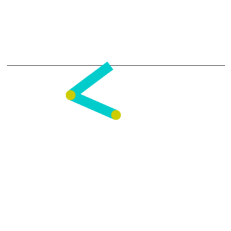

In [7]:
def watch_agent():
  env = gym.make('Acrobot-v1')
  state = env.reset()
  rewards1 = []
  img = plt.imshow(env.render(mode='rgb_array'))
  action_space = np.arange(env.action_space.n)
  for t in range(10000):
    pred = policy_est.predict(state).detach().numpy()
    action = np.random.choice(action_space, p=pred)

    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    state, reward, done, _ = env.step(action)
    rewards1.append(reward)
    if done:
        print("Reward:", sum([r for r in rewards]))
        break 
  env.close()

watch_agent()

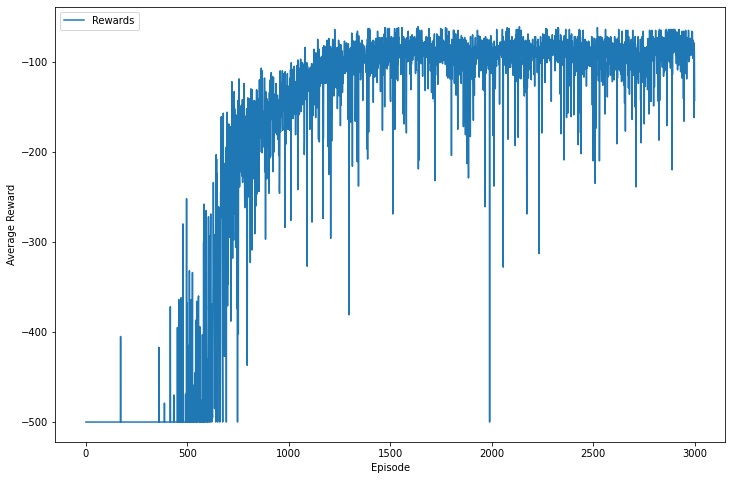

In [8]:
plt.figure(figsize=(12,8))
plt.plot(rewards, label='Rewards')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.show()